In [1]:
# execute this cell before you start

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras as keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)
print(tf.keras.__version__)


2023-04-24 16:51:36.869672: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.12.0
2.12.0


#  CA2

to submit the assignment, please do the following:

- make sure that the notebook runs through and produces all desired output after `Kernel -> Restart & Run all`
- running through the whole notebook must not take no more than 60 minutes on a standard computer, similar to our lab-computers, without GPU and 8GB of RAM
- do `Cell -> All output -> Clear` to clear all your output
- save the notebook (CA2.ipynb)
- upload the file `CA2.ipynb` to canvas.
- note that Google Colab ipynb files do not work with the nbgrader system I use to grade assignments and are therefore not allowed. 


# Q1 The CIFAR-10 dataset.

(10 marks)

Consider the data in  [`keras.datasets.cifar10`](https://www.tensorflow.org/datasets/catalog/cifar10) and train a network which reliably categorizes the data. 
Try to understand tradeoffs:

- What increases computing time?
- What increases accuracy?

This dataset has its own [Wikipedia page](https://en.wikipedia.org/wiki/CIFAR-10), and is often used as benchmark for new proposed methods. 
You can take the cat/dog example from the lecture as a starting point, but you can also find plenty of inspiration in the Internet.  As before, it is not forbidden to get such inspiration, but please stay in the framework of what is covered in the lecture and clearly cite from where you take what. 


To get you started, here some code to show with which you can browse the data:

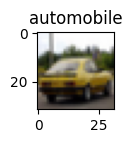

interactive(children=(IntSlider(value=24999, description='k', max=49999), Output()), _dom_classes=('widget-int…

In [2]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

(train_data,train_labels),(test_data,test_labels) = keras.datasets.cifar10.load_data()


from ipywidgets import interact

@interact(k=(0, len(train_data)-1))
def myplot(k):
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.set_title(labels[train_labels[k][0]])
    ax.imshow(train_data[k])


# Inspection of the CIFAR-10 dataset 

In [3]:
(train_data,train_labels),(test_data,test_labels) = keras.datasets.cifar10.load_data()

In [4]:
train_data.shape, type(train_data)

((50000, 32, 32, 3), numpy.ndarray)

In [5]:
test_data.shape, type(test_data)

((10000, 32, 32, 3), numpy.ndarray)

CIFAR-10 dataset is, as seen above, split into 50,000 training images and 10,000 testing images.

Each item (i.e. image) in the dataset is a 32x32, 3 channel image hence the 32, 32, 3.

Considering the introduction to the task given above, the CIFAR-10 dataset has 10 different categories for the images to be classified into. 

The original labels are encoded as a numpy array. They are represented as integers ranging from 0 to 9. 

In [6]:
train_labels.shape, type(train_labels)

((50000, 1), numpy.ndarray)

In [7]:
unique_labels = np.unique(test_labels)
print(unique_labels)

[0 1 2 3 4 5 6 7 8 9]


To have more convinient access to the target labels during the training and evaluation of the data, it is useful to name them. These categories are shown below:

In [8]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [9]:
# Processing the counts for each label in the training set
unique_labels, label_counts = np.unique(train_labels, return_counts=True)
# np.unique() returns an array of unique values from labels (i.e. each unique category), return_counts = True returns the number of times each unique item appears

# Displaying the counts for each label
for label, count in zip(unique_labels, label_counts):
  #zip() to iterate over unique_labels and label_counts in parallel and be able to count how many instances belong to each category
    print(f"{count} instances belong to label {labels[label]}")

5000 instances belong to label airplane
5000 instances belong to label automobile
5000 instances belong to label bird
5000 instances belong to label cat
5000 instances belong to label deer
5000 instances belong to label dog
5000 instances belong to label frog
5000 instances belong to label horse
5000 instances belong to label ship
5000 instances belong to label truck


Clearly there are 10 classes, with 5,000 images per class within the training dataset. 

Given that the test set is represented by 10,000 items, an additional 1,000 instances belong to each category.

Overall, the CIFAR-10 dataset has 6,000 images per class, with 10 classes in total. The dataset is balanced. 

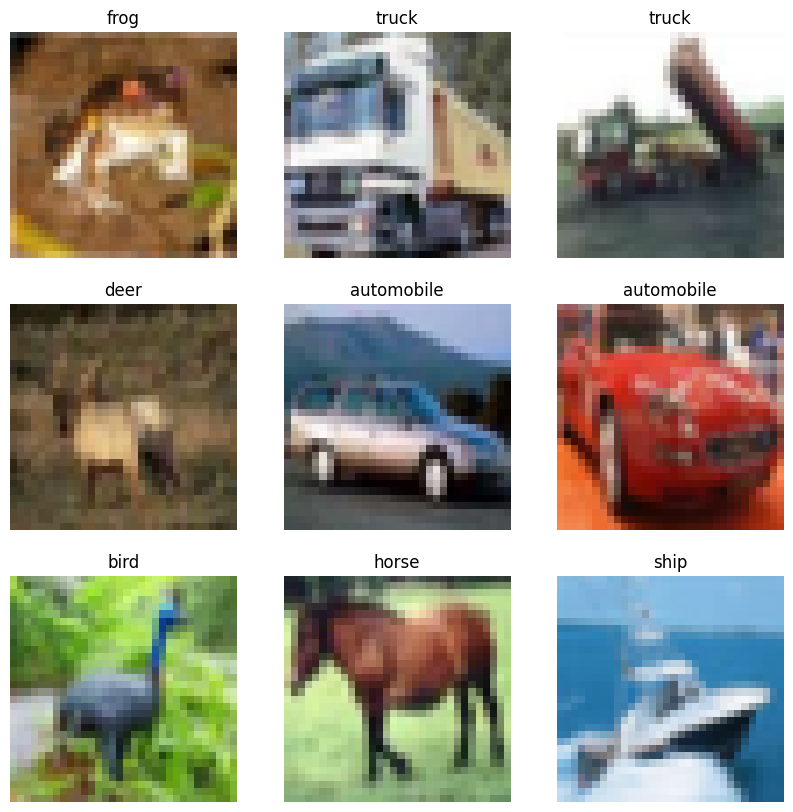

In [10]:
# Plotting of images to track how certain modifications affect the input data
# Below the original input data is shown

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(train_data[i])
    plt.title(labels[train_labels[i][0]])
    plt.axis("off")

# Preprocessing of the dataset

## Data Normalisation

The first issue to tackle in the task is the image input.

Each image is of size 32x32 pixels. To take a look at the first row of image number 1:

In [11]:
train_data[1][0]

array([[154, 177, 187],
       [126, 137, 136],
       [105, 104,  95],
       [102, 101,  99],
       [125, 131, 139],
       [155, 166, 180],
       [172, 190, 210],
       [180, 199, 214],
       [142, 156, 156],
       [111, 120, 110],
       [106, 107,  98],
       [109, 104, 102],
       [123, 121, 117],
       [127, 129, 127],
       [181, 188, 189],
       [217, 226, 229],
       [209, 211, 211],
       [166, 167, 162],
       [164, 165, 156],
       [158, 160, 148],
       [116, 117, 103],
       [102, 101,  83],
       [ 95,  95,  76],
       [ 90,  89,  79],
       [ 72,  70,  69],
       [ 60,  60,  61],
       [ 56,  57,  54],
       [ 77,  78,  72],
       [ 94,  96,  84],
       [ 91,  95,  71],
       [ 87,  90,  71],
       [ 79,  81,  70]], dtype=uint8)

It appears that the data is of type uint8, which refers to 8 bits of unsigned integers--> each number is between 0 and 255.

It is necessary to preprocess the data before feeding it into the network. 

As interpreted on this webiste (https://machinelearningmastery.com/how-to-normalize-center-and-standardize-images-with-the-imagedatagenerator-in-keras/), both pixel standardization and pixel normalization could be a good choice. 

Pixel normalization would fix pixel values into a [0,1] range which would help prevent numerical instability during training. This way each pixel is a decimal between 0 and 1 (0 = black, 1 = white).

Pixel standardization, on the other hand, scales pixels to have zero mean and unit variance. It is really useful if the images have a wide range of brightness or contrast values. 
To inspect this, one can refer to the plot of the original images above. It is noticable that the contrast is significant between the different regions of the image. This makes it more challenging to preprocess the images and train the network. 

Considering that it would be benefitial to reduce the effects of lighting and color variations, pixel standardization seems to be a better fit for the dataset. 

To further ensure that standardization is the technique to choose instead of normalization, one must inspect whether pixels have a similar range across all images in the dataset.  

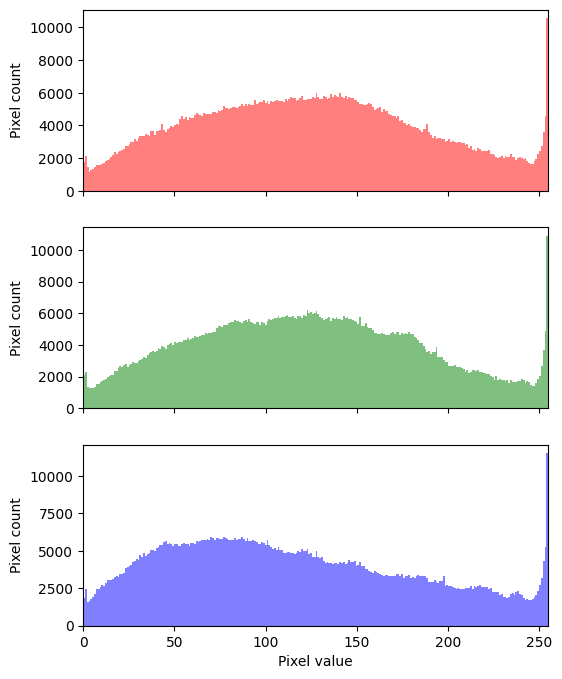

In [12]:
from tensorflow import keras

# Loading of the CIFAR-10 dataset
(train_images, train_labels), _ = keras.datasets.cifar10.load_data()

# Selecting a random sample of images
num_images = 1000
indices = np.random.choice(len(train_images), num_images, replace=False)
images = train_images[indices]

# Plotting histograms of pixel values for each color channel
colors = ['red', 'green', 'blue']
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 8), sharex=True)
for i, color in enumerate(colors):
    axs[i].hist(images[:, :, :, i].flatten(), bins=256, color=color, alpha=0.5)
    axs[i].set_xlim([0, 255])
    axs[i].set_ylabel('Pixel count')
axs[-1].set_xlabel('Pixel value')
plt.show()


Given that pixels for each color channel (red, green, and blue) across all images in the dataset have a similar range, pixel standardization makes more sense. 

One can proceed with pixel standardization:

In [13]:
train_data = (train_data - np.mean(train_data)) / np.std(train_data)
# calculating mean and st dev of pixels in training set
# normalizing pixels by subtracting the mean and dividing by st dev

test_data = (test_data - np.mean(test_data)) / np.std(test_data)
# performing the same preprocessing on the test images as well
# if normalizing the training and not the test set, the test set will have a different distribution of pixels than the training set
# this would lead to poor performance when evaluating the model on the test set

To verify that the preprocessing worked:

In [14]:
train_data[1][0]

array([[ 0.51897733,  0.87751159,  1.03339605],
       [ 0.08250084,  0.25397374,  0.2383853 ],
       [-0.24485653, -0.26044498, -0.40074099],
       [-0.29162187, -0.30721032, -0.33838721],
       [ 0.06691239,  0.16044307,  0.28515064],
       [ 0.53456577,  0.70603868,  0.92427692],
       [ 0.79956936,  1.08016139,  1.39193031],
       [ 0.92427692,  1.2204574 ,  1.45428409],
       [ 0.33191597,  0.55015422,  0.55015422],
       [-0.15132586, -0.01102984, -0.1669143 ],
       [-0.22926809, -0.21367964, -0.35397565],
       [-0.18250275, -0.26044498, -0.29162187],
       [ 0.0357355 ,  0.00455861, -0.05779518],
       [ 0.09808928,  0.12926617,  0.09808928],
       [ 0.93986537,  1.04898449,  1.06457294],
       [ 1.50104943,  1.64134545,  1.68811078],
       [ 1.37634186,  1.40751875,  1.40751875],
       [ 0.70603868,  0.72162713,  0.6436849 ],
       [ 0.67486179,  0.69045023,  0.55015422],
       [ 0.58133111,  0.612508  ,  0.42544665],
       [-0.07338363, -0.05779518, -0.276

Each pixel was centered by subtracting the mean pixel value, and then scaled by dividing by standard deviation. 

To observe the changes it made visually:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


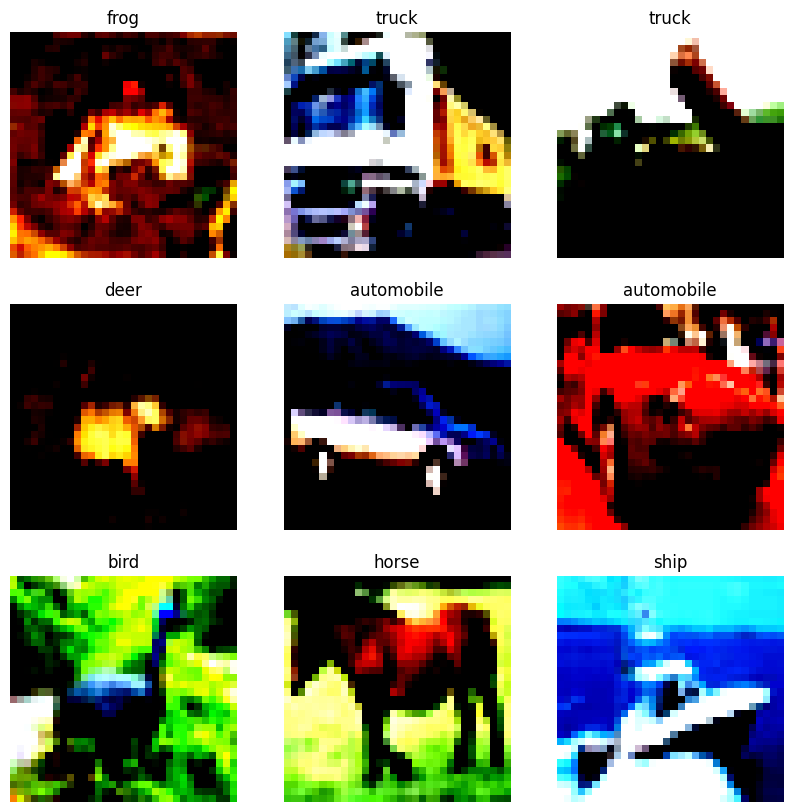

In [15]:
# Plotting of images to track how pixel standardization affected it

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(train_data[i])
    plt.title(labels[train_labels[i][0]])
    plt.axis("off")

Initially, the pixels were in the range of 0 to 255. Standardising them to have zero mean and unit variance can result in pixel values that are negative or outside the original range - some of the pixels might become negative, while others greater than 255. 

To plot the normalized images, pixels are rescaled to fit within the original range of 0 to 255. This can result in images appearing darker or with less contrast than originals. 
The reason for thi is because the normalized pixel values are spread over a smaller range of values, so the differences between the darkest and brightest pixels is smaller. 

# Building + Training + Evaluation of the Model

Considering how this is a multi-class image classification problem, the intuitive approach to the task is to use Convolutional Neural Networks (CNNs).

To figure out what would be a good starting point for the model architecture, several resources have been considered. The most significant of them are from Tensorflow and Jason Brownlee. The resources can be found on these URLs: https://www.tensorflow.org/tutorials/images/cnn and https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/ 

Additionally, in an effort to compile the data preprocessing and model architecture within one cell, the function below is defined. This is the approach that was undertaken in L07 as well which also serves as great inspiration for this task. 

Firstly the cell will load in all the necessary libraries.

This is followed by defining a function which will start a timer and load the CIFAR-10 dataset, as well as define the 4 individual sets of data--> the training and test data, and their respective labels.

To ensure that the data is on a common scale, pixel standardization is performed for the reasons discussed above. In short, it is important because having different scales for different features can negatively affect the model's performance, in additon to standardization allowing faster convergance during training. 

The next step is to define the architecture of the neural network. 

For the 'basic' architecture of the model that is going to be trained and evaluated on the CIFAR-10 dataset, the following specifications were chosen:

The first block implements a 2D convolutional layer, followed by a 2D maxpooling layer and ending with a dropout layer.

The convolutional layer is there to extract the features of the CIFAR-10 images. Specifically, Conv2D was chosen as it is generally performs better for images (https://stats.stackexchange.com/questions/295397/what-is-the-difference-between-conv1d-and-conv2d). The specified number of filters is 32 as it is a good starting point for the convolutional layer to use each of those filters to extract a specific pattern from the images. Padding was chosen as 'same' meaning that the output feature maps will have the same spatial dimensions as the input feature maps. This is important because there is no loss of spatial information that way. Finally, the ReLU activation function is applied to the resulting feature maps.

Now, both MaxPooling and Dropout layers can help in regularizing the model and prevent overfitting, but they do so in different ways:

MaxPooling seemed like a good fit to reduce the dimensionality of the images (https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwj6ns-iz8L-AhUCbsAKHRR6AGAQFnoECDgQAQ&url=https%3A%2F%2Fwww.mdpi.com%2F1999-4893%2F15%2F11%2F391%2Fpdf&usg=AOvVaw25KW4YHsFJ22IRZb-tt_5C). Esentially, this layer reduces the spatial dimensions of the outputted feature maps. As a consequence, it reduces the computational complexity of the model while retaining the most important features. This helps to improve the stability and robustness of the model.

Integration of dropout layers is also beneficial in the extent of being able to provide higher accuracy by reducing overfitting. Randomly dropping some neuros (setting them to 0) prevents the model from becoming too dependent on a single feature from the training set. This allows for an improvement in the model's ability to generalize to new data leading to higher accuracy. Here, 25% of the input units will be randomly dropped out during each training iteration.

The next block includes a Flattening layer, a Dense layer and a Dropout layer following it. 
The flatten() layer transforms the 3D image vector into 1D. The purpose is that so the outputted feature maps from the convolutional layer, which performed the feature extraction, is flatted so it can be adequatly feed into to the fully connected dense layer with 128 nodes. This layer then interprets the output from the previous layer. 

The last block is for the output layer. It includes a dense layer with 10 nodes with softmax as its activation function. The 10 nodes correspond to the number of classes in the CIFAR-10 dataset, with softmax giving the probabilities of each class.

The next steps are to compile the model with the loss function being Sparse Categorical Crossentropy, the optimizer being Adam, and the metric being accuracy. 

Sparse Categorical CrossEntropy is used when the classes are mutually exclusive - which is the case in CIFAR-10. 

Adam optimizer should be a good choice as it was shown it performs well on a wide range of tasks and it has the added benefit of updating the weights after each iteration. 

Once that is done, the model must be trained. This is done via the '.fit' method on the training images and labels, which also does a split of the data into a validation split because it can serve as an evaluation set to monitor training of the model. 

In addition, the batch_size was changed from the default 32 to 64 in order to have faster computation- overfitting was not a large concern due to adequate regularization. 

Finally, the trained model is evaluted on the test set.

It should be noted that certain information is stored from training- the most relevant for the assignment being training loss, validation loss, training accuracy and validation accuracy. 
It is possible to plot them to get an insight into how the model is performing, and that was done in the line after evaluation on test data. 

To get a perspective on how the model is prediciting some of the images from the CIFAR-10 dataset, a code to do that was included. (the code to execute that was modified from https://www.kaggle.com/code/sid2412/cifar10-cnn-model-85-97-accuracy/notebook)

Lastly, the timer is stopped, and the total time needed to complete all the abovementioned steps for the specified function is calculated. 

In [16]:
# Starting model

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import time

def train_evaluate_model(input_shape, num_classes):

  # Starting the time counter to be able to monitor and compare computational time
  start_time = time.time()

  # Loadinf of the CIFAR-10 dataset
  (train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

  # Preprocessing the dataset via pixel standardisation
  train_images = (train_images - np.mean(train_images)) / np.std(train_images)
  test_images = (test_images - np.mean(test_images)) / np.std(test_images)

  # Defining model architecture
  model_input = keras.layers.Input(shape=input_shape)

  # First block with a convolutional layer
  x = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(model_input)
  x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = keras.layers.Dropout(0.25)(x)

  # Fully connected layer block
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(units=128, activation="relu")(x)
  x = keras.layers.Dropout(0.5)(x)

  # Output layer
  output = keras.layers.Dense(units=num_classes, activation="softmax")(x)
  model = keras.Model(inputs=model_input, outputs=output)

  # Compiling model
  model.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=["accuracy"])

  # Training model
  history = model.fit(train_images, train_labels, epochs=10, validation_split=0.1, batch_size = 64)

  # Evaluating model
  test_loss, test_acc = model.evaluate(test_images, test_labels)
  print("Test loss:", test_loss)
  print("Test accuracy:", test_acc)

  # Plotting loss and accuracy during training
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  # Checking the predictions
  test_predictions = np.argmax(model.predict(test_images), axis=1)
  fig, axes = plt.subplots(5, 5, figsize=(12,12))
  axes = axes.ravel()
  for i in np.arange(25):
      axes[i].imshow(test_images[i])
      axes[i].set_title('True: %s \nPredict: %s' % (labels[test_labels[i][0]], labels[test_predictions[i]]))
      axes[i].axis('off')
  plt.subplots_adjust(wspace=1)
  plt.show()

  # Stopping the time counter
  end_time = time.time()

  total_time = end_time - start_time
  print(f"Total time: {total_time} seconds")

Epoch 1/10
704/704 [==============================] - 22s 29ms/step - loss: 1.7313 - accuracy: 0.3625 - val_loss: 1.3355 - val_accuracy: 0.5334
Epoch 2/10
704/704 [==============================] - 19s 27ms/step - loss: 1.4687 - accuracy: 0.4604 - val_loss: 1.2294 - val_accuracy: 0.5670
Epoch 3/10
704/704 [==============================] - 19s 27ms/step - loss: 1.3790 - accuracy: 0.4972 - val_loss: 1.1906 - val_accuracy: 0.5998
Epoch 4/10
704/704 [==============================] - 19s 27ms/step - loss: 1.3199 - accuracy: 0.5224 - val_loss: 1.1206 - val_accuracy: 0.6184
Epoch 5/10
704/704 [==============================] - 19s 27ms/step - loss: 1.2708 - accuracy: 0.5356 - val_loss: 1.1322 - val_accuracy: 0.6204
Epoch 6/10
704/704 [==============================] - 19s 27ms/step - loss: 1.2496 - accuracy: 0.5460 - val_loss: 1.0994 - val_accuracy: 0.6240
Epoch 7/10
704/704 [==============================] - 19s 27ms/step - loss: 1.2215 - accuracy: 0.5598 - val_loss: 1.0661 - val_accuracy:

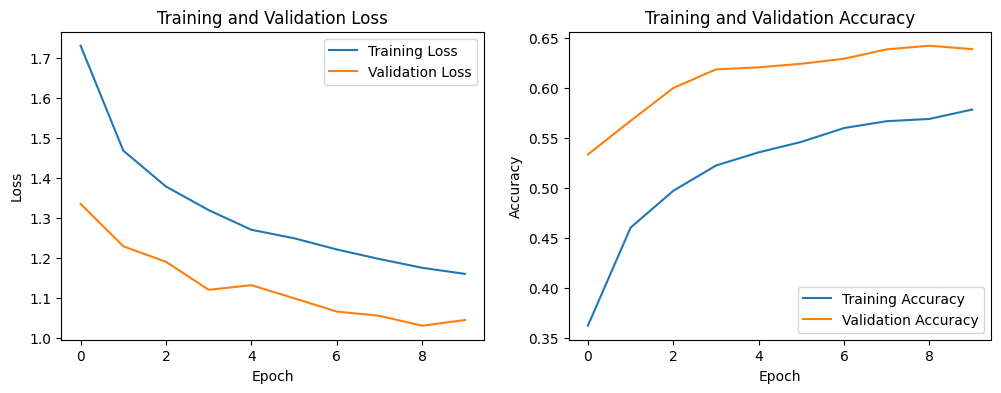

313/313 [==============================] - 1s 4ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

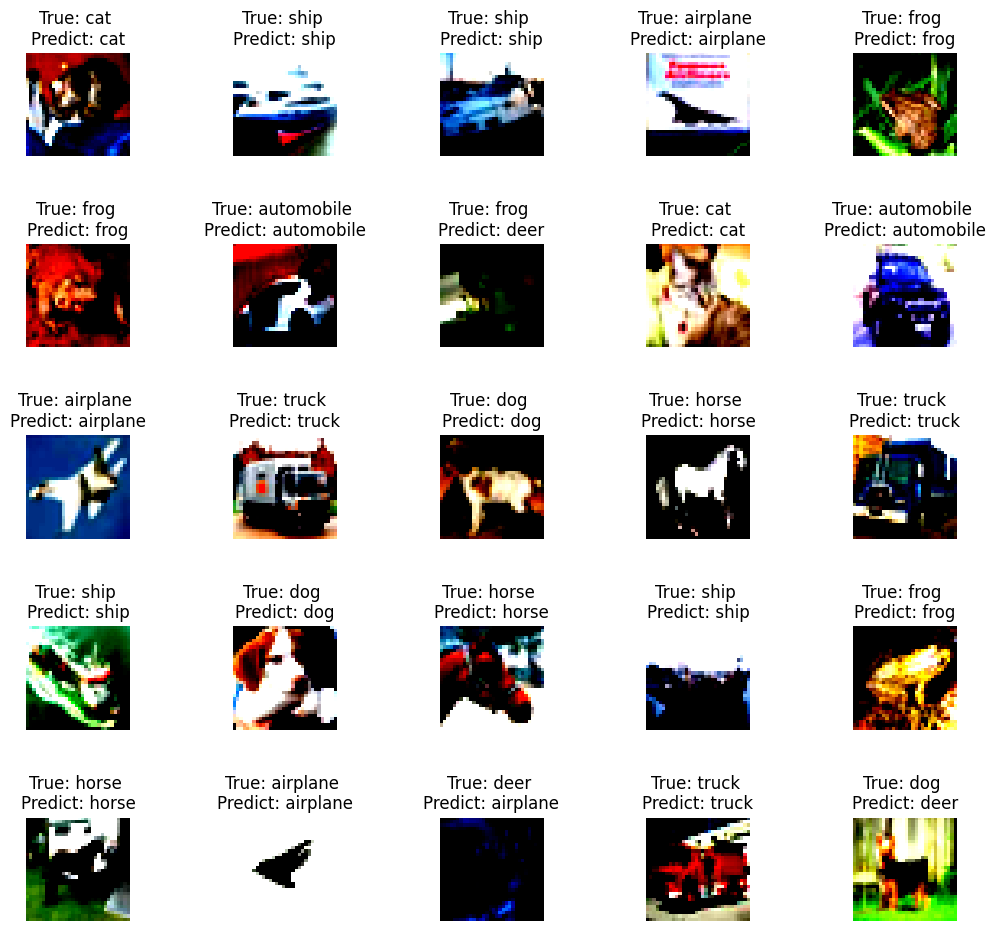

Total time: 197.9193835258484 seconds


In [17]:
input_shape = (32, 32, 3)
num_classes = 10
train_evaluate_model(input_shape, num_classes)

The model achieved 63.46% accuracy when evaluated on the test dataset. This indicates the percentage of images in the test set that the model correctly classified.This is relatively okay, but one can expect more to done. This is especially so since only a single convolutional layer was used to extract features from the input images. For further improvements to the accuracy, adding more trainable layers makes sense.

To reflect on the plots as well, it should first be clarified that the blue line represents performance on the training dataset and orange line performance on the validation set. A well performing model has decreasing loss and increasing accuracy over time for both the training and validation sets. This seems to be true of this configuration, but being at a clear drawback with the test accuracy, an increase in the number of epochs should be considered. This model appears to be underfitting - training loss is decreasing and continues to decrease at the end of the plot, conveying that the model is capable of learning more and that the training process was halted prematurely, hence the suggestion to increase epochs.
In addition, the curves appear to be relatively smooth, indicating that the model is making gradual improvements with each epoch and the training process is stable.

In the grand scheme of things, the model seems to be performing relatively well in terms of predictions. The big issue is that the images are of low resolution, so even with certain images where the model made a mistake in the predicition, it could be argued that the human eye could make the mistake as well. 

Moreover, an important feature of this performance is that it took around 3 minutes. This indicates that the proposed modifications of adding more layers and increasing the number of epochs (which in in of themselves increase the computational time) can be applied as they wont endanger the models computational performance at this stage.

# Attempts to improve performance

## Modifications to model architecture

For the suggested strategy to improve the performance of the model, most of the code is left as is, with the exception of the modifications below:

1. Increasing the number of epochs from 10 to 30.

2. Adding another convolutional layers, which means that the first one has 32 and the next one 64 filters. This is done in an effort to extract more complex features with this added layer. 

Adding more convolutional layers should increase the computational time because more matrix multiplications and convolutions are being executed on input feature maps, as well as increasing epochs because there is more training iterations. 

In order to be conscious of the expected computational strain, the dense layer will stay as is with its 128 nodes. 

In [18]:
# Improved model - added convolutional layer

def train_evaluate_model(input_shape, num_classes):

  # Starting the time counter to be able to monitor and compare computational time
  start_time = time.time()

  # Loadinf of the CIFAR-10 dataset
  (train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

  # Preprocessing the dataset via pixel standardisation
  train_images = (train_images - np.mean(train_images)) / np.std(train_images)
  test_images = (test_images - np.mean(test_images)) / np.std(test_images)

  # Defining model architecture
  model_input = keras.layers.Input(shape=input_shape)

  # First block with a convolutional layer
  x = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(model_input)
  x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = keras.layers.Dropout(0.25)(x)

  # Second block with a convolutional layer
  x = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(x)
  x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = keras.layers.Dropout(0.25)(x)

  # Fully connected layer block
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(units=128, activation="relu")(x)
  x = keras.layers.Dropout(0.5)(x)

  # Output layer
  output = keras.layers.Dense(units=num_classes, activation="softmax")(x)
  model = keras.Model(inputs=model_input, outputs=output)

  # Compiling model
  model.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=["accuracy"])

  # Training model
  history = model.fit(train_images, train_labels, epochs=30, validation_split=0.1, batch_size = 64)

  # Evaluating model
  test_loss, test_acc = model.evaluate(test_images, test_labels)
  print("Test loss:", test_loss)
  print("Test accuracy:", test_acc)

  # Plotting loss and accuracy during training
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  # Checking the predictions
  test_predictions = np.argmax(model.predict(test_images), axis=1)
  fig, axes = plt.subplots(5, 5, figsize=(12,12))
  axes = axes.ravel()
  for i in np.arange(25):
      axes[i].imshow(test_images[i])
      axes[i].set_title('True: %s \nPredict: %s' % (labels[test_labels[i][0]], labels[test_predictions[i]]))
      axes[i].axis('off')
  plt.subplots_adjust(wspace=1)
  plt.show()

  # Stopping the time counter
  end_time = time.time()

  total_time = end_time - start_time
  print(f"Total time: {total_time} seconds")

Epoch 1/30
704/704 [==============================] - 29s 40ms/step - loss: 1.6503 - accuracy: 0.4029 - val_loss: 1.3351 - val_accuracy: 0.5390
Epoch 2/30
704/704 [==============================] - 27s 38ms/step - loss: 1.3427 - accuracy: 0.5179 - val_loss: 1.1147 - val_accuracy: 0.6146
Epoch 3/30
704/704 [==============================] - 28s 39ms/step - loss: 1.2100 - accuracy: 0.5688 - val_loss: 0.9964 - val_accuracy: 0.6566
Epoch 4/30
704/704 [==============================] - 28s 39ms/step - loss: 1.1337 - accuracy: 0.6022 - val_loss: 0.9381 - val_accuracy: 0.6760
Epoch 5/30
704/704 [==============================] - 27s 39ms/step - loss: 1.0703 - accuracy: 0.6221 - val_loss: 0.8795 - val_accuracy: 0.7028
Epoch 6/30
704/704 [==============================] - 27s 38ms/step - loss: 1.0282 - accuracy: 0.6344 - val_loss: 0.8639 - val_accuracy: 0.7022
Epoch 7/30
704/704 [==============================] - 27s 38ms/step - loss: 0.9922 - accuracy: 0.6542 - val_loss: 0.8213 - val_accuracy:

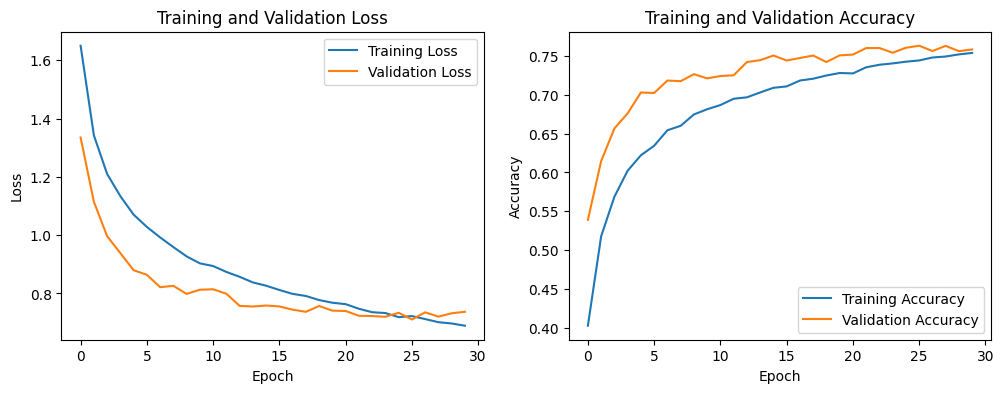

313/313 [==============================] - 2s 5ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

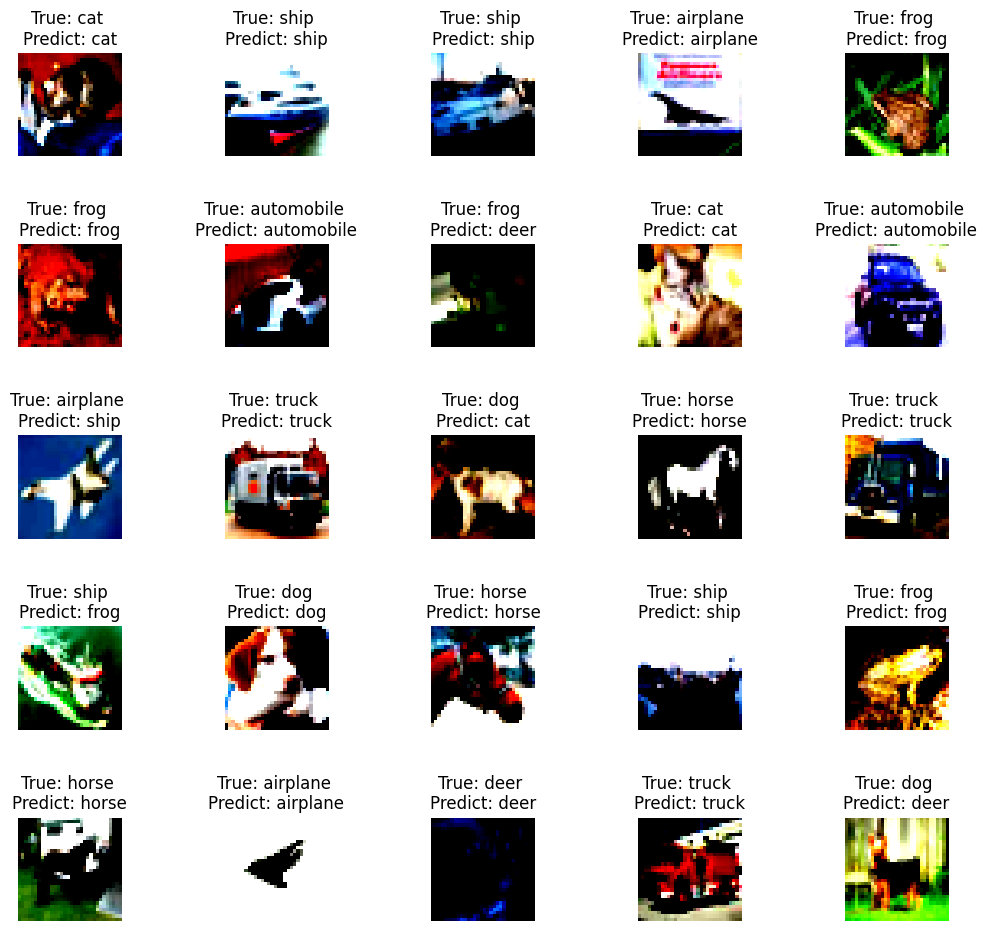

Total time: 863.7227320671082 seconds


In [19]:
input_shape = (32, 32, 3)
num_classes = 10
train_evaluate_model(input_shape, num_classes)

In the attempted model, increased accuracy and lower loss were achieved. Compared to the inital model with its test accuracy of 63.46%, this model's value of 74.68% is a fairily big improvement. 

In terms of what can be extracted from the plots, it appears that it was useful to allow for the model to train for longer. The drawback is that the curves are a bit rougher than the previous 'basic' model implying that the model is not converging as smoothly, but it doesn't seem to be overly exagurated. 

Clearly, being that the test accuracy increased, the proportion of correctly assigned labels to the inputted images is higher.

Lastly, there was also a significant increase in the computational time. From 198secs to 864secs i.e. from around 3 to 14 minutes. This still seems fine and is within the time restrictions of the assignment. 

## Data Augmentation

As was tackeld in L07, data augmentation provides a useful technique to "artifically increase the data with modified copies of the available data". The result of this an increase in the diversity of the training data and improve the ability of the model to generalize. 

This is performed via applying random transformations to the images like rotation, translation, flipping, and cropping.

In [20]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
     # randomly flips (50-50% probabiblity) an image horizontally 
        layers.experimental.preprocessing.RandomRotation(0.1),
     # randomly rotates the image by a maximum of 10% of the original image size in either direction
        layers.experimental.preprocessing.RandomZoom(0.1),
     #randomly zoomed in or out by a maximum of 10% --> max zoom factor = 1.1 OR min = 0.9. 
    ]
)

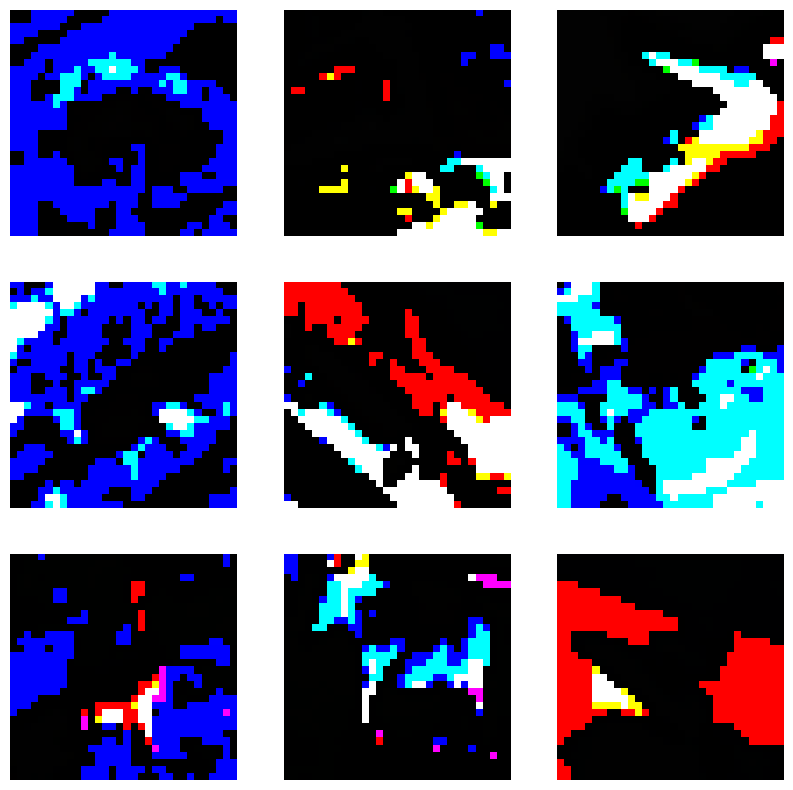

In [21]:
# Plotting of images to visualize how data augmentation affected it

plt.figure(figsize=(10, 10))
for i in range(9):
  #looping over first 9 images 
    augmented_image = data_augmentation(train_data[i:i+1])
    #applying data augmentation to those first 9 in the training dataset 
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    #plotting of those 9
    plt.axis("off")


The displayed images dont resemble the original input. 
However, a possible explanation is first to do with the pixel standardization which transformed some pixels to have negative values and has the effect disscussed before. This could affect the result of the data augmentation, since some image transformations, such as the RandomFlip and RandomZoom, may amplify these negative values, resulting in a predominantly blue and red pattern on a black background.

As was recommended by Jason Brownlee on (https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/): "Given that the dataset is comprised of small photos of objects, we do not want to use augmentation that distorts the images too much...The types of random augmentations that could be useful include a horizontal flip, minor shifts of the image, and perhaps small zooming or cropping of the image."

These suggestions have been taken into consideration and the data augmentation block was incorporated into the function below:

In [22]:
# Improved model but w/ data augmentation

def train_evaluate_model(input_shape, num_classes):
  
  start_time = time.time()

  # Loading of the CIFAR-10 dataset
  (train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

  # Preprocessing the dataset using pixel standardisation
  train_images = (train_images - np.mean(train_images)) / np.std(train_images)
  test_images = (test_images - np.mean(test_images)) / np.std(test_images)

  # Adding data augmentation
  data_augmentation = keras.Sequential(
      [
          keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
          keras.layers.experimental.preprocessing.RandomRotation(0.1),
          keras.layers.experimental.preprocessing.RandomZoom(0.1),
      ]
  )

  # Defining model architecture
  model_input = keras.layers.Input(shape=input_shape)

  # First block with a convolutional layer
  x = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(model_input)
  x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = keras.layers.Dropout(0.25)(x)

  # Second block with a convolutional layer
  x = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(x)
  x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = keras.layers.Dropout(0.25)(x)

  # Fully connected layer block
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(units=128, activation="relu")(x)
  x = keras.layers.Dropout(0.5)(x)

  # Output layer
  output = keras.layers.Dense(units=num_classes, activation="softmax")(x)
  model = keras.Model(inputs=model_input, outputs=output)

  # Compiling model
  model.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=["accuracy"])

  # Train model
  history = model.fit(train_images, train_labels, epochs=30, validation_split=0.1, batch_size = 64)

  # Evaluate model
  test_loss, test_acc = model.evaluate(test_images, test_labels)
  print("Test loss:", test_loss)
  print("Test accuracy:", test_acc)

  # Plot loss and accuracy during training
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  # Checking the predictions
  test_predictions = np.argmax(model.predict(test_images), axis=1)
  fig, axes = plt.subplots(5, 5, figsize=(12,12))
  axes = axes.ravel()
  for i in np.arange(25):
      axes[i].imshow(test_images[i])
      axes[i].set_title('True: %s \nPredict: %s' % (labels[test_labels[i][0]], labels[test_predictions[i]]))
      axes[i].axis('off')
  plt.subplots_adjust(wspace=1)
  plt.show()

  end_time = time.time()

  total_time = end_time - start_time
  print(f"Total time: {total_time} seconds")

Epoch 1/30
704/704 [==============================] - 32s 44ms/step - loss: 1.7347 - accuracy: 0.3726 - val_loss: 1.3895 - val_accuracy: 0.5086
Epoch 2/30
704/704 [==============================] - 30s 43ms/step - loss: 1.4903 - accuracy: 0.4669 - val_loss: 1.2905 - val_accuracy: 0.5362
Epoch 3/30
704/704 [==============================] - 30s 42ms/step - loss: 1.4008 - accuracy: 0.5003 - val_loss: 1.1574 - val_accuracy: 0.5926
Epoch 4/30
704/704 [==============================] - 31s 44ms/step - loss: 1.3452 - accuracy: 0.5201 - val_loss: 1.1346 - val_accuracy: 0.5974
Epoch 5/30
704/704 [==============================] - 30s 43ms/step - loss: 1.3072 - accuracy: 0.5362 - val_loss: 1.1082 - val_accuracy: 0.6086
Epoch 6/30
704/704 [==============================] - 31s 44ms/step - loss: 1.2724 - accuracy: 0.5488 - val_loss: 1.0782 - val_accuracy: 0.6348
Epoch 7/30
704/704 [==============================] - 30s 43ms/step - loss: 1.2442 - accuracy: 0.5592 - val_loss: 1.0105 - val_accuracy:

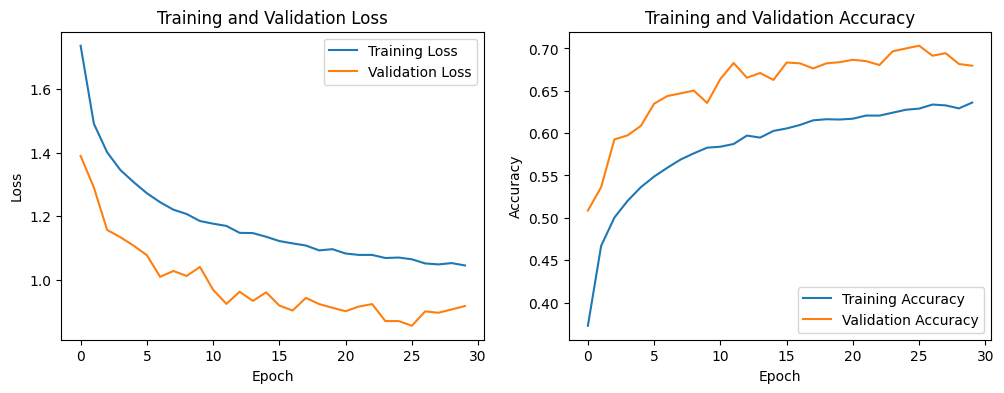

313/313 [==============================] - 2s 6ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

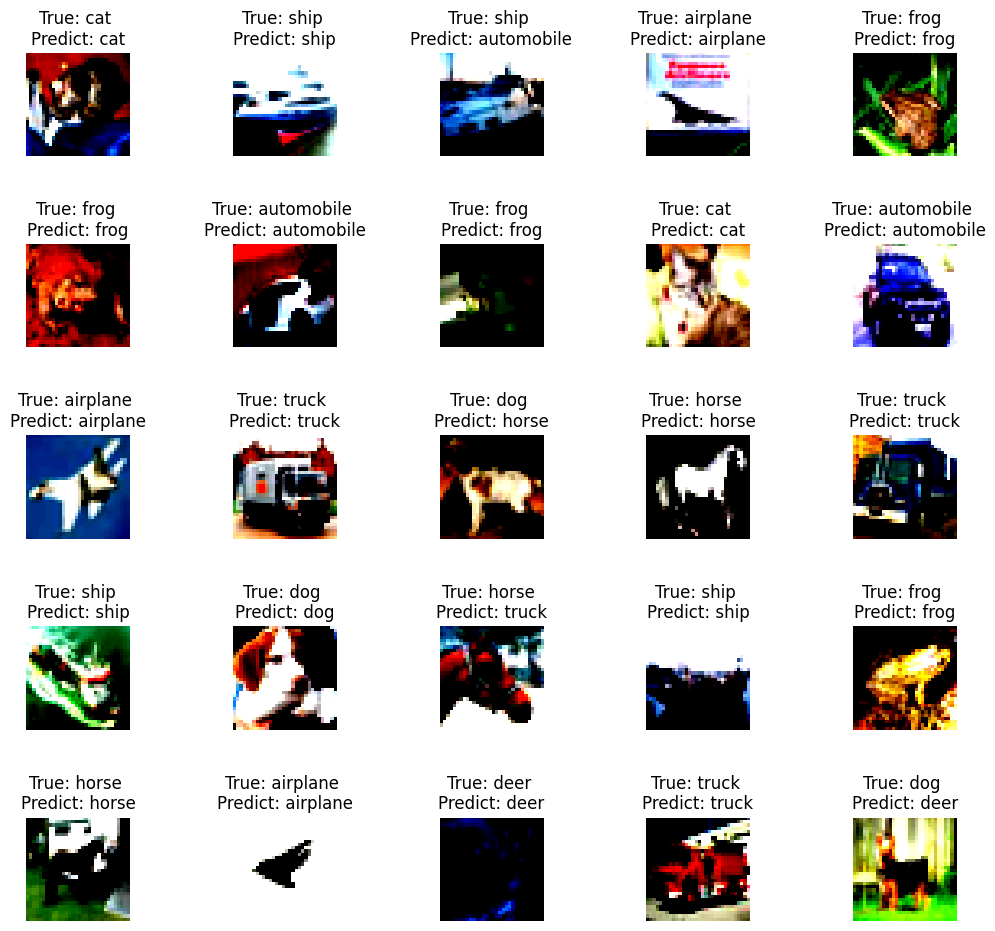

Total time: 928.0178790092468 seconds


In [23]:
input_shape = (32, 32, 3)
num_classes = 10
train_evaluate_model(input_shape, num_classes)

Unfortunately, data augmentation did not have the desired effect.
Compared to the previously improved model, the test accuracy went down to 67.79%.
Reason why this model worse performance than model without data augmentation might be because the added data augmentation techniques might be causing overfitting. Namely, the modifications implemented to artificially increase the size of the training set, could also have lead to a higher variance in the training set, which might have caused the model to overfit.

The plot of training and validation loss and accuracy indicates more instable training as well. The added variance in the training set might also make the training process more unstable, leading to a less smooth plot of validation loss and accuracy over the epochs.

Given that the ability of the model to predict correctly dropped, the proportion of images whose label is predicted correctly fell too. 

The computational time increased in comparison to the previously improved model since an additional step of data augmentation needed to be computed. From 864secs to 928secs, meaning from around 14mins to 15.5mins. This is not as significant of a difference as was observed from the 'basic' to the observed model, but considering the worse performance, the increased computational time is certainly unfortunate. 

# Final improvement attempt

In [36]:
def train_evaluate_model(input_shape, num_classes):
  
  start_time = time.time()

  # Loading of the CIFAR-10 dataset
  (train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

  # Preprocessing the dataset using pixel standardisation
  train_images = (train_images - np.mean(train_images)) / np.std(train_images)
  test_images = (test_images - np.mean(test_images)) / np.std(test_images)

  # Defining model architecture
  model_input = keras.layers.Input(shape=input_shape)

  # First block with a convolutional layer
  x = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same")(model_input)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation('relu')(x)
  x = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same")(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation('relu')(x)
  x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = keras.layers.Dropout(0.25)(x)

  # Second block with a convolutional layer
  x = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same")(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation('relu')(x)
  x = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same")(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation('relu')(x)
  x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = keras.layers.Dropout(0.25)(x)

  # Third block with a convolutional layer
  x = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same")(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation('relu')(x)
  x = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same")(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation('relu')(x)
  x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = keras.layers.Dropout(0.25)(x)

  # Fully connected layer block
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(units=512)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation('relu')(x)
  x = keras.layers.Dropout(0.5)(x)

  # Output layer
  output = keras.layers.Dense(units=num_classes, activation="softmax")(x)
  model = keras.Model(inputs=model_input, outputs=output)

  # Compiling model
  model.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=["accuracy"])

  # Train model
  history = model.fit(train_images, train_labels, epochs=30, validation_split=0.1, batch_size = 64)

  # Evaluate model
  test_loss, test_acc = model.evaluate(test_images, test_labels)
  print("Test loss:", test_loss)
  print("Test accuracy:", test_acc)

  # Plot loss and accuracy during training
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  # Checking the predictions
  test_predictions = np.argmax(model.predict(test_images), axis=1)
  fig, axes = plt.subplots(5, 5, figsize=(12,12))
  axes = axes.ravel()
  for i in np.arange(25):
      axes[i].imshow(test_images[i])
      axes[i].set_title('True: %s \nPredict: %s' % (labels[test_labels[i][0]], labels[test_predictions[i]]))
      axes[i].axis('off')
  plt.subplots_adjust(wspace=1)
  plt.show()

  end_time = time.time()

  total_time = end_time - start_time
  print(f"Total time: {total_time} seconds")

Epoch 1/10
1407/1407 [==============================] - 142s 100ms/step - loss: 1.4723 - accuracy: 0.4851 - val_loss: 1.0258 - val_accuracy: 0.6304
Epoch 2/10
1407/1407 [==============================] - 140s 100ms/step - loss: 0.9755 - accuracy: 0.6552 - val_loss: 0.8493 - val_accuracy: 0.7084
Epoch 3/10
1407/1407 [==============================] - 149s 106ms/step - loss: 0.8325 - accuracy: 0.7118 - val_loss: 0.6994 - val_accuracy: 0.7540
Epoch 4/10
1407/1407 [==============================] - 144s 102ms/step - loss: 0.7384 - accuracy: 0.7435 - val_loss: 0.6405 - val_accuracy: 0.7822
Epoch 5/10
1407/1407 [==============================] - 137s 97ms/step - loss: 0.6734 - accuracy: 0.7666 - val_loss: 0.7086 - val_accuracy: 0.7682
Epoch 6/10
1407/1407 [==============================] - 139s 99ms/step - loss: 0.6226 - accuracy: 0.7842 - val_loss: 0.5419 - val_accuracy: 0.8142
Epoch 7/10
1407/1407 [==============================] - 138s 98ms/step - loss: 0.5739 - accuracy: 0.7997 - val_los

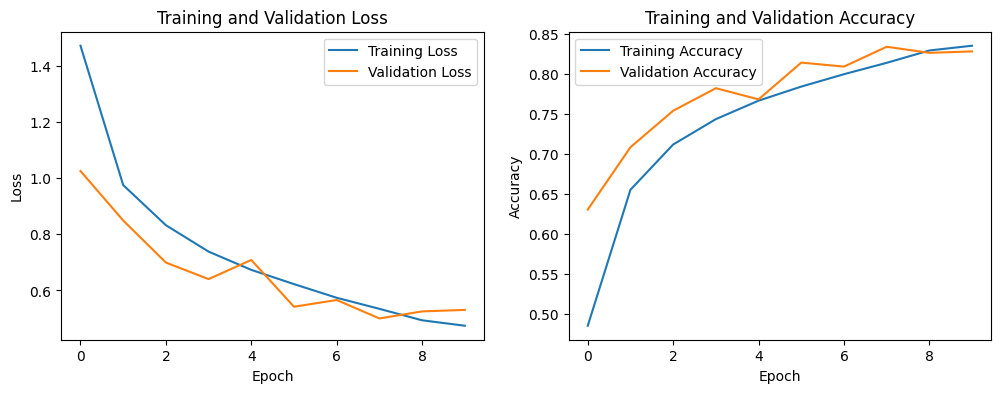

313/313 [==============================] - 6s 20ms/step
Confusion matrix:
[[770  10  40 ...   6  53  24]
 [  4 926   1 ...   0   6  34]
 [ 23   1 653 ...  12   4   4]
 ...
 [  3   0   6 ... 827   1   3]
 [ 28  16   7 ...   0 882  16]
 [  8  61   2 ...   6   9 872]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

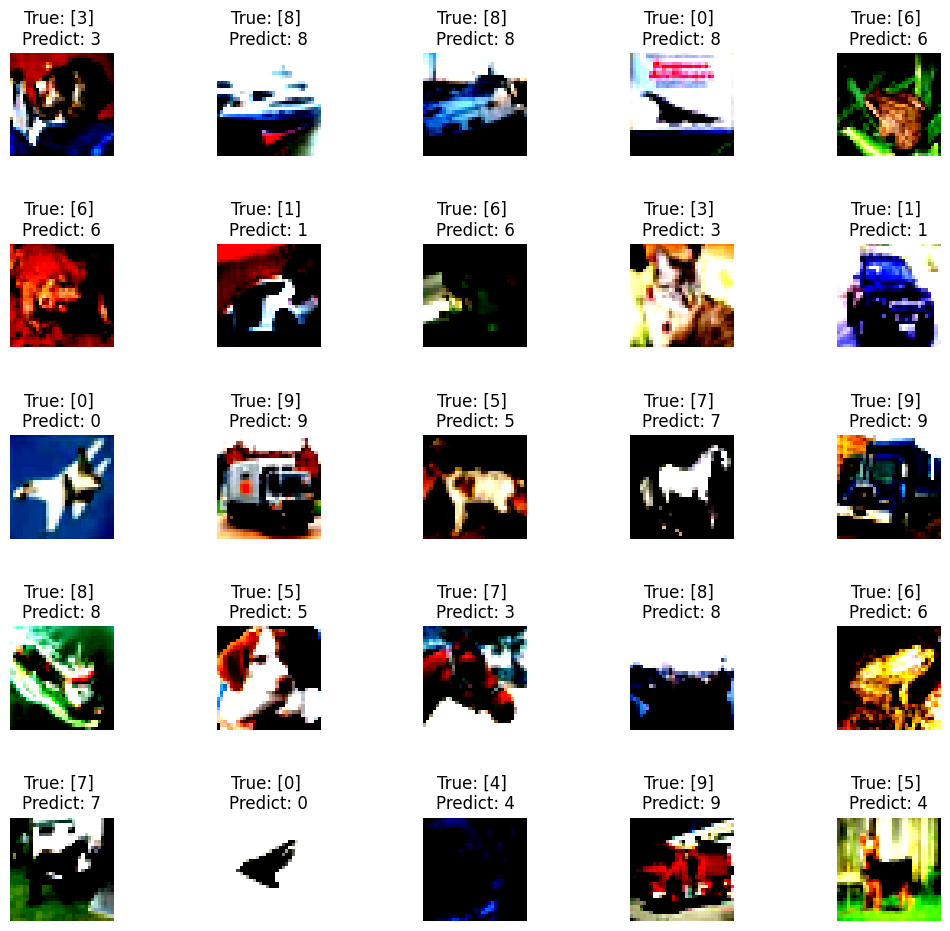

Total time: 1439.6346590518951 seconds


In [37]:
input_shape = (32, 32, 3)
num_classes = 10
train_evaluate_model(input_shape, num_classes)

The model managed to achieve a test accuracy of 85.53% in 1329 seconds (approximately 22mins).

What allowed this superior performace to the model is adding more layers with increasing number of filters, a dense layer with more nodes, and including a batch normalisation layer. 

The added trainable layers aided in allowing the model to learn more and far complex patterns in the input data. More abstract features could be distinguished from added convolutional layers, and they could be interpreated more meaningfully with more nodes in the dense layer. 
Considering the added layers and the consequentally longer computational time, the batch normalisation layer provided faster training via reduction the number of epochs needed to converge. Namely, faster training comes because a batch normlization layer provides the normalization of inputs to each layer- it reduces the amount that distribution of the inputs changes, and this way it reduces the number of epochs needed to converge. 

# Q2 Deep Learning in Genomics 



Consider the following tutorial on using machine learning in genomics:

https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/A_Primer_on_Deep_Learning_in_Genomics_Public.ipynb

a) Thoroughly explain the code in this tutorial by adding markdown cells starting with "# CA" (6 marks)

# 1. Curate the Data

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

SEQUENCES_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/sequences.txt'

sequences = requests.get(SEQUENCES_URL).text.split('\n')
sequences = list(filter(None, sequences))  # This removes empty sequences.

# Let's print the first few sequences.
pd.DataFrame(sequences, index=np.arange(1, len(sequences)+1), 
             columns=['Sequences']).head()

,Sequences
1,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...
2,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...
3,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...
4,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...
5,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...


The initial cell of code in the tutorial loads a sample dataset of DNA sequences which will be used in further build of a neural network.

Firstly, it is necessary to load all the required libraries.

Into a variable 'SEQUENCES_URL', a URL with a .txt file is defined from a GitHub page. 

Into the variable 'sequences', the .txt file from that URL is downloaded via the requests library method '.get'. 
This .txt file is split into a list of DNA sequences, with the empty sequences removed via the 'filter' method

The last line of code converts the list of DNA sequences stored in the 'sequences' variable to a Pandas DataFrame. This facilitates further processing. 
The dataframe has indexing that streches from 1 to the length of the sequences list, and a single column titled 'Sequences'. 
Via .head(), a printout of the first 5 sequences of the dataframe is done. It can be seen how the dataframe is formatted with the rows indicating the index of the sequence, the 'Sequences' labels the type of data the column holds, and the entires of the table are the sequences themselves (DNA sequences). 

In [25]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(categories='auto')   
input_features = []

for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 CCGAGGGCTA ... CGCGGACACC
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 1. 0. 0.]
 [1. 1. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Considering that it is necessary to feed the neural network into something comprehensible to it, one must format the data into tensors. 

This preprocessing step includes the conversion of DNA sequences into a numerical format.

Two classes are imported from scikit-learn library. 

The first used, LabelEncoder, performs the encoding of each base of the DNA sequence as an integer. This will be executed later on in the for loop, but for now it is instantiated as an object named 'integer_encoder'. 

The second used, OneHotEncoder, transform the integer-encoded sequence into a sparse binary matrix. Same as above, this is first instantiated as an object called 'one_hot_encoder'. An additional quirk to this is that it uses the 'auto' categories setting. This essentially implies that 'one_hot_encoder' will determine the unique values in the input data and use those as the number of possible categories.

An empty 'input_features = []' list is initiliazed which will serve to store teh one-hot encoded features of each DNA sequence after the for loop completes. 

The for loop computes *each* input sequence from the previously defined within the 'sequences' variable. 

Firstly, the 'fit_transform' method of LabelEncoder converts the sequence of bases into a sequence of integers. The '.reshape' method manipulates the array of integers so that they are reshaped into a 2D array which will be fed into the one_hot_encoded object - essentially, it is converted into a vertical column of integers where each row is an individual DNA base of the sequence. This is needed because the 'one_hot_encoder' object needs a 2D input array (each row == data point, each column == feature). 

Then, the same method from OneHotEncoder class is used to convert each integer-encoded base into a sparse binary matrix.  A feature is one of the four DNA bases that can appear at each position in a DNA sequence. 
Each base is a vector where only one value is 1 and the rest are 0s. 
Each row of the resulting matrix corresponds to a possible combination of the bases.
One-hot encodeding allows to encode categorical features ('letters' of DNA bases) in a format comprehesible by a neural network.  

The one-hot encoded features for each sequence are appended to the 'input_features' object. The 'np.stack' method stacks the one-hot encoded sequences into a 3D array which will be the fed into the neural network. 

The last lines of code print as an example the first 10 and last 10 bases of the first DNA sequence of the list. Below it prints its corresponding one-hot encoding which 'encodes every base in a sequence in the form of a 4-dimensional vector, with a separate dimension for each base'. This is to be able to visualize how the process went.

It seems that the first row of the matrix corresponds to base 'A', second to 'C', third to 'G', and the last one to 'T'. 


In [26]:
LABELS_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'

labels = requests.get(LABELS_URL).text.split('\n')
labels = list(filter(None, labels))  # removes empty sequences

one_hot_encoder = OneHotEncoder(categories='auto')
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

Labels:
 [['0' '0' '0' ... '0' '1' '1']]
One-hot encoded labels:
 [[1. 1. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]]


Similar as how the DNA sequences have been processed, to extarct the labels, one must first define the URL from which the data will be downloaded - it is stored in 'LABELS_URL'.

This object is used to retrieve the .txt found on that URL. 
Same as with the DNA sequnces from above, the labels are split into individual labels, and empty ones are removed.

Further preprocessing is executed by one hot encoding the labels, where first the 'one_hot_encoder' is initialized. 

Then, the labels are reshaped into a 2D array where each row referes to a single label.

This is followed by applying one hot encoding to the reshaped labels which effectively converts them into a sparse binary matrix. This is stored in the 'input_labels' object. 

As before, to be able to monitor how this preprocessing was executed, the original labels versus the one hot encoded ones were printed. 

The original labels are a one-dimensional array of strings- each string represents the label for a corresponding DNA sequence. '1' represents that a protein binded to the sequence, '0' that it did not. 

Given the context of the tutorial, this would mean that the inputted DNA sequence is a promoter sequence i.e. one that once a protein is bound to it will lead to the initiation of transcription of the gene it encodes. 

Since the neural network requires numerical input, the labels have been one hot encoded. Once that is done, each row of the input_labels array corresponds to a single DNA sequence. The values in each row are the one-hot encoded label values for that sequence.



In [27]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.25, random_state=42)

The code above uses the 'train_test_split' method from the scikit-learn library to split the input features and labels into training and testing sets.

The output is 4 objects - train_features and train_labels are the training subsets of input, whereas test_features and test_labels are for test subsets. 

'test_size' specified the amount of the split - since it is 0.25, it means 25% of the data serves for testing, whereas 75% for training 

The last parameter of the method is random_state. This sets the seed, so every time the code is executed, the same split is made. This aids in having reproducibility of code. 

# 2. Select the Architecture and Train

In [28]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=12, 
                 input_shape=(train_features.shape[1], 4)))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['binary_accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 39, 32)            1568      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 9, 32)            0         
 )                                                               
                                                                 
 flatten_3 (Flatten)         (None, 288)               0         
                                                                 
 dense_6 (Dense)             (None, 16)                4624      
                                                                 
 dense_7 (Dense)             (None, 2)                 34        
                                                                 
Total params: 6,226
Trainable params: 6,226
Non-trainable params: 0
____________________________________________________

'model' object is initalized with 'Sequential' which will allow for the layers imported above to be added into this model. 

The addition are done via 'model.add'. 

The first layer to be added is the convolutional 1D layer- Conv1D is chosen as it is used generally for 'texts' which is how the sequence of bases of DNA sequences can be regarded.

It specified 32 as the size of filters.  This number determines the number of patterns the model can learn - with more filters, the model can learn more complex representations of data.

Next, the kernel_size of 12 is chosen. This number determines the size of the learned patterns in the data. Presumably, it was chosen as 12 becuase it is the common length of DNA motifs important for transcription. The filters will investigate a 12-nucleotide sequence in each go and search for useful patterns.

The last parameters is 'input_shape' which refers to the number of features, and 4 as the one-hot encoding of the four DNA nucleotides.

Next layer is 'MaxPooling1D'. It is useful in reducing the number of parameters in the network. 
Namely, the convolutional layer applied 32 filters to the input sequences which resulted in feature maps. 
The max pooling layer serves to reduce the dimensionality of each feature map by taking the maximum value within a sliding window of size 4. 

Moving along, the next layer is Flatten() which flattens the output of the previous layers (a 3D tensor) into a single vector (1D tensor). This is important to have adequate input ot the next layer which is a Dense one. 

The first dense layer is a fully connected one with 16 nodes and a ReLU activation function. It serves to introduce non-linearity to the model and increase capacity to learn complex patterns. ReLu is the activiation function of choice as it was shown it is effective in many types of networks.

The last/output layer is another Dense one with 2 nodes and a softmax activation function- softmax is suitable for binary classification as it is able to output a probability distribution over the two possible labels. This layer makes the final assigning of labels i.e. whether the inputted sequence is a promoter sequence or not. 

In terms of the model compilation, the loss funciton, the optimizer and the metric to evaluate training are selected.

Considering that this task is a binary classification problem, binary cross-entropy is an appropriate loss function.

Furthemore, the Adam optimizer was chosen since it performs well on a wide range of tasks.

Lastly, the metric to evaluate performance is 'binary_accuracy' which is convinient for a binary classification problem.

The last line prints a summary of the networks architecture.
Some key features of this table are:


The output shape of the convolutional layer is (None, 39, 32). It refers to a tensor with a shape of (batch_size, sequence_length, number_of_filters). 
This means it outputs a 39 by 32 matrix for each input sequence. 
In addition, it has 1,568 trainable parameters. 

*note: batch size can be left unspecified during model definition to allow for variable batch sizes when model is trained and evaluated later on

The max pooling layer reduces the input shape from (None, 39, 32) to (None, 9, 32), and it has no trainable parameters 

The flatten layer flattens the output of max pooling into a vector of size (None, 288)

The output shape of the first dense layer is (None, 16), with its 4,624 trainable parameter

The output shape of the output layer is (None, 2) with 34 trainable parameters.

The total number of parameters is also listed (6,226). These trainable parameters are weights and biases of relevamt layers that will be updated during training.


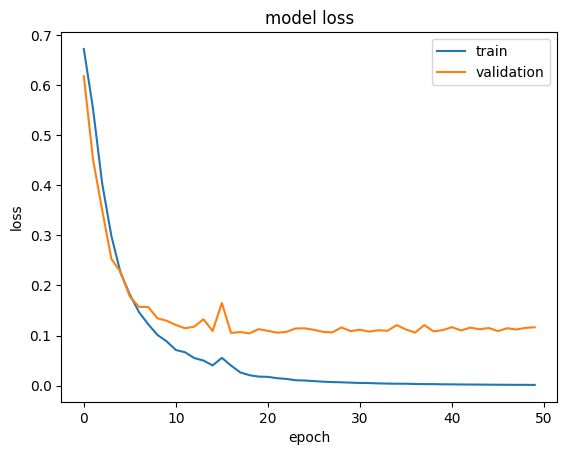

In [30]:
history = model.fit(train_features, train_labels, 
                    epochs=50, verbose=0, validation_split=0.25)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()
     

Firtsly, a 'history' object is defined which will store the data processed during training. 

Within it, it was specified to train the model on the input train_features and train_labels for 50 epochs. 
The 'validation_split' parameter picked how much of the training data will be used to extarct a validation set to be able to monitor performance (25% was picked for the validation set). 
Additionally 'verbose' = 0 means that training will not be printed to the console.

plt.figure() creates a figure to plot. Specifically, it will be a figure to plot the loss during training. 

As mentioned the history object stores a lot of information computed during training (when .fit is executed)- history['loss'] is one of those thigs. It plots the training loss over epochs. In addition, history['val_loss'] is also computed to show the validation loss over epochs. 

Further aestetic modifications are made to the plot, like giving names to the axis, adding a legend and giving a title. 

The last line allows for the plot to be shown. 

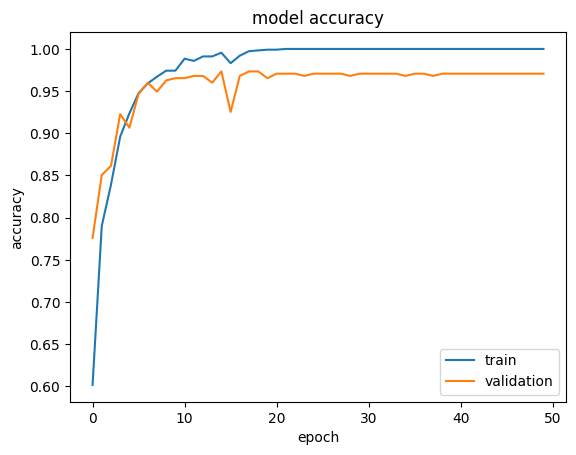

In [31]:
plt.figure()
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

The cell above performs a very similar computation, but from the point of view of accuracy - specifically binary accuracy. 

Since the task is to classify DNA sequences as binding a protein or not, binary_accuracy is an appropriate metric to evaluate accuracy.

Overall, these 2 plots help to visualize the training and validation loss and accuracy during training. 

By examining the plots, one can observe how well the model is learning to classify DNA sequences, and whether it is overfitting or underfitting.

# 3. Evaluate


16/16 [==============================] - 0s 1ms/step
Confusion matrix:
 [[250   9]
 [  3 238]]


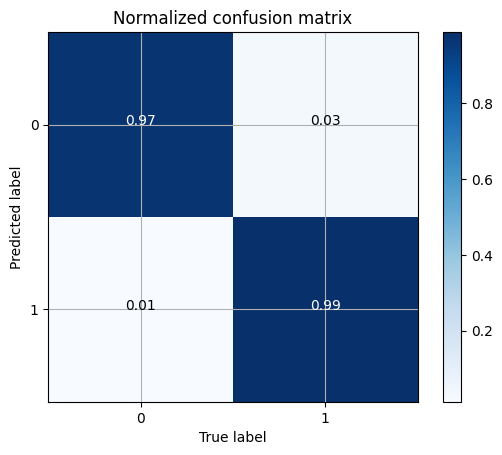

In [32]:
from sklearn.metrics import confusion_matrix
import itertools

predicted_labels = model.predict(np.stack(test_features))
cm = confusion_matrix(np.argmax(test_labels, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')

The code above evaluates the performance of the trained model on an unseen test set.

The 'predicted_labels' object stores the predicted labels which were computed using the trained model which made predictions on the test set.

'cm' initialized an object that will represent the confusion matrix- it helps to more thoroughly evaluate how the model is performing in classifying each sequence to its correct labels. 
Within the 'cm' object, a confusion matrix is calculated using the true labels of the test set and the predicted labels from the 'predicted_labels' object. The argmax() method converts the one-hot encoded labels to their appropraite integer values.

To get a more comprehesible output the line 
'cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]'
normalizes the confusion matrix so it can show the proportion of true labels that were correctly predicted for each class.

Further lines of code deal with the modficication of the visual representation of the confusion matrix - its title, the axis labels, adding a color bar to indicate the scale of the color map, displaying the numerical values in each cell etc. 


# 4. Interpret


In [33]:
import tensorflow.keras.backend as K

def compute_salient_bases(model, x):
  input_tensors = [model.input]
  gradients = model.optimizer.get_gradients(model.output[0][1], model.input)
  compute_gradients = K.function(inputs = input_tensors, outputs = gradients)
  
  x_value = np.expand_dims(x, axis=0)
  gradients = compute_gradients([x_value])[0][0]
  sal = np.clip(np.sum(np.multiply(gradients,x), axis=1),a_min=0, a_max=None)
  return sal

First and foremost, the tutorial mentions a saliency map. This is a technique to help identify which input feature i.e. nucleotide has the most influence on the model's prediction

The computation breaks down into computing the gradient of the model's prediction with respect to each individual nucleotide. A saliency map is obtained and one can see the contribution of each individual nucleotide of the input DNA sequence to the model's prediction.

With some background knowledge from the given URL (https://faroit.com/keras-docs/1.2.0/backend/), we will begin to refer to the code:

The first peculiarity is importing the 'keras.backend' which provides a low-level API to compute operations in TensorFlow.

Next, a function is definied under the name 'compute_salient_bases'. Its input parameters are the 'model' and the input tensor 'x'. 'model' is the trained neural network, whereas 'x' is a single DNA sequence.

The 'input_tensors' objects stores as a list the input tensor of the trained model - it defines the shape and data type of the input data. This is importnat becuase it is needed to compute the saliency map, which is the gradient of the model's prediction with respect to each individual nucleotide. This input tensor can be accessed via the 'input' attribute for the model object.

Moving on, the 'gradients' object stores the calculatation of gradients of the output of model (model.output[0][1]) with respect to the input tensor (model.input) using the optimizer used to compile the model. '[0][1]' refers to the second output of the model, which is the probability of the input sequence belonging to class 1 i.e. that the protein binds to the sequence. This is necesssary for this computation because the goal is to compute gradients with respect to the input tensor to see which nucleotides contribute the most to the classification.

Furthermore, a function is computed within the 'compute_gradients' object. Specifically, it is created via the Keras backend function K.function(), which takes 'input_tensors' as input and returns 'gradients'.

'x_value' prepares the inputted sequence 'x' for the computation to produce a saliency map. It does so by expands the dimensions of the input sequence x so it can be passed to the 'compute_gradients' function. The output stored in 'x_value' object is a 3D tensor with (1, L, 4)--> 1 is the batch size, L is the length of the input sequence, 4 is the the one-hot encoding of each base. This is the format that the 'compute_gradients' function accepts. 

The next line returns a list of arrays containing the computed gradients.
Considering the previously mentioned batch size of 1, list contains only one element. In that case, first [0] selects the only element in the LIST, which is the array containing the gradients. The second [0] selects the first element in the ARRAY since there's only one input tensor in this case.
Reason for choosing the first element of the first array is because the aim is to extract only the gradients of the first input tensor of the model i.e. the specified DNA sequence in the form of a one-hot encoded matrix. This way, the gradients of other input tensors are ignored. 

The second to last line defines the 'sal' object which stores the calculatation for the saliency map. It performs certain operations like multiplication and sum on gradients and the input tensor. The clip method ensures that all values are non-negative.

The last line returns the computed map. 

In [34]:
sequence_index = 1999  # You can change this to compute the gradient for a different example. But if so, change the coloring below as well.
sal = compute_salient_bases(model, input_features[sequence_index])

plt.figure(figsize=[16,5])
barlist = plt.bar(np.arange(len(sal)), sal)
[barlist[i].set_color('C1') for i in range(5,17)]  # Change the coloring here if you change the sequence index.
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(len(sal)), list(sequences[sequence_index]));
plt.title('Saliency map for bases in one of the positive sequences'
          ' (green indicates the actual bases in motif)');

AttributeError: 'Adam' object has no attribute 'get_gradients'

'sequence_index' stores the index of the DNA sequence from the input data for which the saliency map should be produced, in this case it is DNA sequence with index 1999

'sal' is an object which calls the 'compute_salient_bases' function. Thanks to this, saliency map is computed. The input to the function is the model trained beforehand, and the input features for the DNA sequence with the number specified in 'sequence_index'.

The remaining lines deal with the plotting of the saliency map - specifying the size of the figure, creating a bar plot of the saliency values for each nucleotide in the DNA sequence, coloring the bars in the plot to indicate which nucleotides are part of the motif, adding labels to axis etc. 


The cell ran the following error upon execution:

"AttributeError: 'Adam' object has no attribute 'get_gradients'"

The 'get_gradients' method is used in the 'compute_salient_bases' function to calculate the gradients of the model's output with respect to the input tensor. This is related to the second part of this task which tackles the version compatibility issues. 

b) Some code in this tutorial was written for an outdated version of Tensorflow 1.x.  Modify it so that it runs on the current version 2.x without using a compatibility layer. I.e. use `gradient.tape()` to calculate gradients, etc. (4 marks)

Compatibility layers are tools provided by a library to ensure compatibility with previous versions.

gradient.tape() belongs to the TensorFlow 2.x versions as can be informed from here: https://www.tensorflow.org/api_docs/python/tf/GradientTape.
It is used for automatic differentiation which helps to compute gradients with respect to its input variables.

Text(0.5, 1.0, 'Saliency map for bases in one of the positive sequences (green indicates the actual bases in motif)')

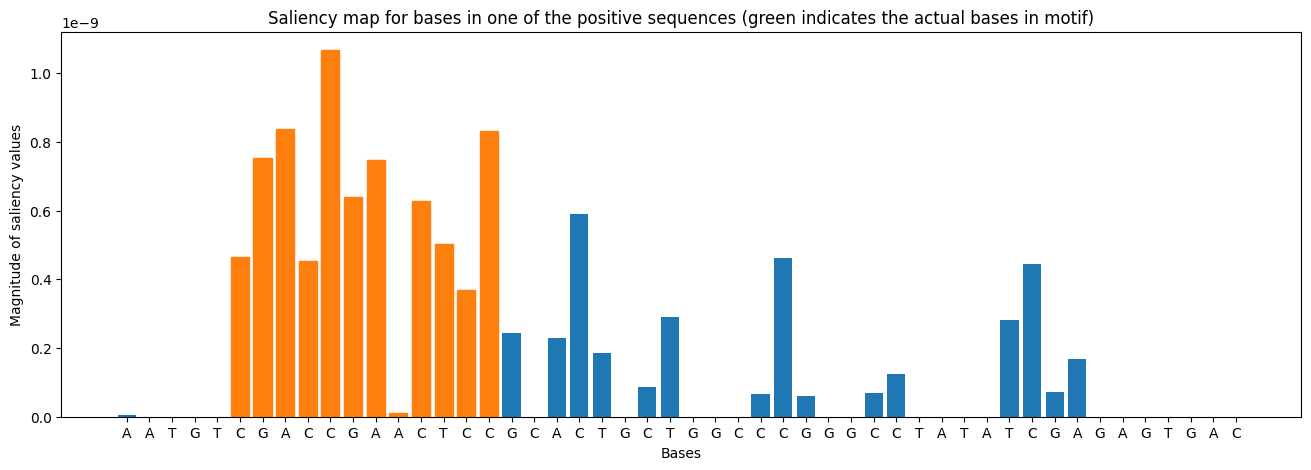

In [35]:
def compute_salient_bases(model, x):
    @tf.function
    def compute_gradients(x):
        with tf.GradientTape() as tape:
            tape.watch(x)
            y = model(x)
            y = y[0,1]  
            # Only computing saliency for label which denotes that the protein binded
        return tape.gradient(y, x)

    x_value = tf.expand_dims(x, axis=0)
    gradients = compute_gradients(x_value).numpy()[0]
    sal = np.clip(np.sum(np.multiply(gradients,x), axis=1),a_min=0, a_max=None)
    return sal

sequence_index = 1999  # You can change this to compute the gradient for a different example. But if so, change the coloring below as well.
sal = compute_salient_bases(model, input_features[sequence_index])

plt.figure(figsize=[16,5])
barlist = plt.bar(np.arange(len(sal)), sal)
[barlist[i].set_color('C1') for i in range(5,17)]  # Change the coloring here if you change the sequence index.
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(len(sal)), list(sequences[sequence_index]));
plt.title('Saliency map for bases in one of the positive sequences'
          ' (green indicates the actual bases in motif)')

To obtain a functional code with the current version it was neccesary to modify a few lines. 

Namely, these mainly had to do with the computation of the gradients and how the tensors were processed.

One of the more 'arbitrary' changes was to remove the import of the keras.backend module.

Next, to be able to compute the gradients of the output with respect to the input tensor, the K.function() method had to be removed. The meaningful method for this in TensorFlow 2.x is to use tf.GradientTape()
More specifically, using the code from https://www.tensorflow.org/api_docs/python/tf/GradientTape as inspiration, the 'compute_gradients' function was adjusted. It uses tf.GradientTape to watch the input tensor x, then it computes the output of the model y, and then computes the gradient of y[0,1] (the saliency for the label which denotes that the protein binded to the sequence i.e. that sequence is a promoter sequence) with respect to x. 
The function is then called with the input tensor x_value to compute the gradients for the input sequence.

Another change has to do with re-adjusting so that the expansion the dimensions of the input sequence x was performed as 'tf.expand_dims' instead of 'np.expand_dims.'. This is becuase TensorFlow 2.x requires all operations to be performed using its tensors.

The last meaningful change is replace 'model.output[0][1]' with 'y[0,1]' to get the saliency for the label which denotes that the protein binded to the sequence because thanks to TensorFlow 2.x, one can access the output of the model directly as a tensor.


Overall, the higher the gradient value, the more important that nucleotide is for the prediction. 

The map can help identify important regions in the input sequence, in this case important motifs in promoter sequnces which bind the transcription factor proteins and aid in initializing transcription of that gene.